# Data Understanding/Preparation (Datenaufbereitungsprozess)

Installieren der aktuellen Matplotlib-Version, da diese nicht standardmäßig in Colab installiert ist.

In [ ]:
!pip install -U matplotlib

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly as plotly
from datetime import datetime
import dateutil.parser as parser
import matplotlib.dates as mdates
from xgboost import XGBRegressor

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
CSV_PC = '/content/drive/MyDrive/sensalytics/Rohdaten/PC_EN.csv'
CSV_PQM = '/content/drive/MyDrive/sensalytics/Rohdaten/PQM_EN.csv'

### Einlesen des Person Count CSV's:

Dieser Datensatz enthält Informationen über die allgemeine Auslastung und das Wetter.

In [ ]:
df_pc = pd.read_csv(CSV_PC, delimiter=';')
df_pc.head(5)

Date (Business Date)     Time  ... Visitor Out Ø Occupancy
0      Thu, 12/08/2021  06:56 h  ...           1           0
1      Thu, 12/08/2021  06:58 h  ...           1          -1
2      Thu, 12/08/2021  06:59 h  ...           1          -1
3      Thu, 12/08/2021  07:00 h  ...           0           1
4      Thu, 12/08/2021  07:01 h  ...           0           4

[5 rows x 8 columns]

Da nur diese CSV-Datei einen Timestamp besitzt wird dieser entfernt und mit Hilfe der beiden Spalten **Date (Business Date)** und **Time** ein neuer Timestamp erzeugt, da diese Spalten in beiden CSV-Dateien vorhanden sind. Dafür wurde die beiden Spalten gemerget wobei das *h* aus der Time-Spalte entfernt wird. Danach werden die nun nicht mehr benötigten Spalten gedroppt und die neue Spalte **Date_Time** zum Pandas Datentyp *datetime* konvertiert. Durch den Datentyp *datetime* ist es möglich den Datensatz schnell und einfach zu sortieren.

In [ ]:
# Merge Date and Time Column and remove 'h'.
df_pc['Date_Time'] = df_pc['Date (Business Date)'] + ' ' + df_pc['Time'].str[:-2]

# Drop of the unneccessary columns.
df_pc = df_pc.drop(['Date (Business Date)', 'Time', 'Timestamp'], axis=1)

# Convert to datetime.
df_pc['Date_Time'] = pd.to_datetime(df_pc['Date_Time'], dayfirst=True)

# Display new dataframe
display(df_pc.head(5))

Weather Description  Ø Temperature  ...  Ø Occupancy           Date_Time
0           clear sky          22.83  ...            0 2021-08-12 06:56:00
1           clear sky          22.83  ...           -1 2021-08-12 06:58:00
2           clear sky          22.83  ...           -1 2021-08-12 06:59:00
3           clear sky          22.83  ...            1 2021-08-12 07:00:00
4           clear sky          22.83  ...            4 2021-08-12 07:01:00

[5 rows x 6 columns]

Der Dataframe wird sortiert um die zeitliche Reihenfolge zu behalten. Das ist wichtig, damit RNN diese Informationen modellieren können.

In [ ]:
# Reorder dataframe
column_names = ['Date_Time', 'Weather Description', 'Ø Temperature', 'Visitor In', 'Visitor Out', 'Ø Occupancy']
df_pc = df_pc.reindex(columns=column_names)
display(df_pc.head(5))

Date_Time Weather Description  ...  Visitor Out  Ø Occupancy
0 2021-08-12 06:56:00           clear sky  ...            1            0
1 2021-08-12 06:58:00           clear sky  ...            1           -1
2 2021-08-12 06:59:00           clear sky  ...            1           -1
3 2021-08-12 07:00:00           clear sky  ...            0            1
4 2021-08-12 07:01:00           clear sky  ...            0            4

[5 rows x 6 columns]

Überblick der ersten Zeilen des Datensatzes. Auffällig sind die vorhandenen negativen Werte in der Spalte **Ø Occupancy**. Diese können so nicht vorkommen, da es keine negative Anzahl an Menschen in einem Supermarkt geben kann. Die Werte sind wahrscheinlich durch Mitarbeiter entstanden, die den Laden verlassen haben und durch einen anderen Zugang wieder betreten haben.

In [ ]:
df_pc.describe()

Ø Temperature    Visitor In   Visitor Out   Ø Occupancy
count   84615.000000  84615.000000  84615.000000  84615.000000
mean       17.778320      3.864669      3.707392    148.261467
std         7.192033      2.908309      2.496350    105.712074
min         2.560000      0.000000      0.000000    -10.000000
25%        11.760000      2.000000      2.000000     72.000000
50%        17.010000      3.000000      3.000000    113.000000
75%        23.460000      5.000000      5.000000    211.000000
max        35.800000     24.000000     19.000000    493.000000

Mit Hilfe der Funktion *describe()*, erkennt man das der minimale Wert in der Spalte **Ø Occupancy** ```-10.00000``` beträgt. Diese negativen Werte müssen durch ```0``` ersetzt werden.



In [ ]:
df_pc['Ø Occupancy'] = df_pc['Ø Occupancy'].clip(lower=0)
df_pc.describe()

Ø Temperature    Visitor In   Visitor Out   Ø Occupancy
count   84615.000000  84615.000000  84615.000000  84615.000000
mean       17.778320      3.864669      3.707392    148.268688
std         7.192033      2.908309      2.496350    105.701841
min         2.560000      0.000000      0.000000      0.000000
25%        11.760000      2.000000      2.000000     72.000000
50%        17.010000      3.000000      3.000000    113.000000
75%        23.460000      5.000000      5.000000    211.000000
max        35.800000     24.000000     19.000000    493.000000

In [ ]:
display(df_pc.head(5))

Date_Time Weather Description  ...  Visitor Out  Ø Occupancy
0 2021-08-12 06:56:00           clear sky  ...            1            0
1 2021-08-12 06:58:00           clear sky  ...            1            0
2 2021-08-12 06:59:00           clear sky  ...            1            0
3 2021-08-12 07:00:00           clear sky  ...            0            1
4 2021-08-12 07:01:00           clear sky  ...            0            4

[5 rows x 6 columns]

In [ ]:
df_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84615 entries, 0 to 84614
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date_Time            84615 non-null  datetime64[ns]
 1   Weather Description  84615 non-null  object        
 2   Ø Temperature        84615 non-null  float64       
 3   Visitor In           84615 non-null  int64         
 4   Visitor Out          84615 non-null  int64         
 5   Ø Occupancy          84615 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 3.9+ MB


Der Datentyp *object* des Merkmals **Weather Description** muss in einem weiteren Schritt in einen numerischen umgewandelt werden, da diese nicht in KNN verwendet werden können.

### Einlesen des PQM-CSV's:

Dieser Datensatz enthält Informationen über die Auslastung der Kassen und die Personenanzahl im Kassenbereich. Die Personenanzahl im Kassenbereich (**Ø Total Occupancy (Payer)**) stellt die Zielvariable dar.

In [ ]:
df_pqm = pd.read_csv(CSV_PQM, delimiter=';')
display(df_pqm.head(5))

Date (Business Date)     Time  POS served  Ø Total Occupancy (Payer)
0      Thu, 12/08/2021  06:55 h           0                          0
1      Thu, 12/08/2021  06:56 h           0                          0
2      Thu, 12/08/2021  06:57 h           0                          0
3      Thu, 12/08/2021  06:58 h           2                          0
4      Thu, 12/08/2021  06:59 h           0                          0

Mit Hilfe der beiden Spalten **Date (Business Date)** und **Time** wird ein neuer Timestamp erzeugt, da diese Spalten in beiden CSV-Dateien vorhanden sind. Dafür wurde die beiden Spalten gemerged wobei das *h* aus der Time-Spalte entfernt wird. Danach werden die nun nicht mehr benötigten Spalten gedroppt und die neue Spalte **Date_Time** zum Pandas Datentyp *datetime* konvertiert.

In [ ]:
# Merge Date and Time Column and remove 'h'.
df_pqm['Date_Time'] = df_pqm['Date (Business Date)'] + ' ' + df_pqm['Time'].str[:-2]

# Drop of the unneccessary columns.
df_pqm = df_pqm.drop(['Date (Business Date)', 'Time'], axis=1)

# Convert to datetime
df_pqm['Date_Time'] = pd.to_datetime(df_pqm['Date_Time'], dayfirst=True)

# Display new dataframe
display(df_pqm.head(5))

POS served  Ø Total Occupancy (Payer)           Date_Time
0           0                          0 2021-08-12 06:55:00
1           0                          0 2021-08-12 06:56:00
2           0                          0 2021-08-12 06:57:00
3           2                          0 2021-08-12 06:58:00
4           0                          0 2021-08-12 06:59:00

Der Dataframe wird darauf hin ebenfalls sortiert.

In [ ]:
# Reorder dataframe
column_names = ['Date_Time', 'POS served', 'Ø Total Occupancy (Payer)']
df_pqm = df_pqm.reindex(columns=column_names)
display(df_pqm.head(5))

Date_Time  POS served  Ø Total Occupancy (Payer)
0 2021-08-12 06:55:00           0                          0
1 2021-08-12 06:56:00           0                          0
2 2021-08-12 06:57:00           0                          0
3 2021-08-12 06:58:00           2                          0
4 2021-08-12 06:59:00           0                          0

In [ ]:
df_pqm.describe()

POS served  Ø Total Occupancy (Payer)
count  89278.000000               89278.000000
mean       3.156433                   8.561751
std        1.732213                   6.028295
min        0.000000                   0.000000
25%        2.000000                   4.000000
50%        3.000000                   8.000000
75%        4.000000                  12.000000
max       10.000000                  48.000000

In [ ]:
df_pqm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89278 entries, 0 to 89277
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date_Time                  89278 non-null  datetime64[ns]
 1   POS served                 89278 non-null  int64         
 2   Ø Total Occupancy (Payer)  89278 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.0 MB


Da keine weiteren Aufälligkeiten in diesem Datensatz vorhanden sind, können die beiden Dataframes nun miteinander verbunden/gemerged werden.

### Verbinden der beiden Dataframes mit merge (InnerJoin):

Die beiden Dataframes werden verbunden und anhand der vorhanden Timestamps geschaut welche Werte in beiden Dataframes vorhanden sind. Die Methode könnte angepasst werden. Danach wird *Date_Time* als Index gesetzt und der neue Dataframe noch einmal anhand des Indexes sortiert.

In [ ]:
df = pd.merge(left=df_pc, right=df_pqm, how='inner', on='Date_Time')
df.set_index('Date_Time', inplace=True)
df.sort_index(inplace=True)

display(df.head(5))

Weather Description  ...  Ø Total Occupancy (Payer)
Date_Time                                ...                           
2021-08-12 06:56:00           clear sky  ...                          0
2021-08-12 06:58:00           clear sky  ...                          0
2021-08-12 06:59:00           clear sky  ...                          0
2021-08-12 07:00:00           clear sky  ...                          0
2021-08-12 07:01:00           clear sky  ...                          0

[5 rows x 7 columns]

### Extraktion der zeitlichen Informationen:

Da zeitliche Informationen ebenfalls eine Rolle spielen und es sehr interessant ist, an welchem Tag die meisten Menschen in den Laden kommen, werden anhand des Timestamps unterschiedliche Informationen extrahiert.

In [ ]:
# Monat: Integer [0-11] (1=Januar, 12=Dezember)
df['Month'] = df.index.month

# Wochentag: Integer [0-6] (0=Montag, 6=Sonntag)
df['Weekday'] = df.index.weekday

# Wochenende: Integer [0,1] (1=Wochenende, 0=Wochentag)
df['Weekend'] = (df.index.dayofweek > 4).astype(int)

# Stunde: Integer [0-24] 
df['Hour'] = df.index.hour

Mit der Funktion *info()* kann man die Datentypen der einzelnen Spalten herausfinden. So wird für die Spalte **Weather Description** der Dtype *Object* angezeigt, weshalb diese noch in einen numerischen Datentyp umgewandelt werden muss.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84615 entries, 2021-08-12 06:56:00 to 2021-11-17 21:32:00
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Weather Description        84615 non-null  object 
 1   Ø Temperature              84615 non-null  float64
 2   Visitor In                 84615 non-null  int64  
 3   Visitor Out                84615 non-null  int64  
 4   Ø Occupancy                84615 non-null  int64  
 5   POS served                 84615 non-null  int64  
 6   Ø Total Occupancy (Payer)  84615 non-null  int64  
 7   Month                      84615 non-null  int64  
 8   Weekday                    84615 non-null  int64  
 9   Weekend                    84615 non-null  int64  
 10  Hour                       84615 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 7.7+ MB


Describe gibt einen sehr guten Überblick über die gesamten numerischen Merkmale des Datensatzes.

In [ ]:
df.describe()

Ø Temperature    Visitor In  ...       Weekend          Hour
count   84615.000000  84615.000000  ...  84615.000000  84615.000000
mean       17.778320      3.864669  ...      0.278757     13.922366
std         7.192033      2.908309  ...      0.448390      4.209714
min         2.560000      0.000000  ...      0.000000      6.000000
25%        11.760000      2.000000  ...      0.000000     10.000000
50%        17.010000      3.000000  ...      0.000000     14.000000
75%        23.460000      5.000000  ...      1.000000     18.000000
max        35.800000     24.000000  ...      1.000000     22.000000

[8 rows x 10 columns]

### Null-Value Überprüfung und Anzahl der einzigartigen Werte der Merkmale:

Hier wird überprüft ob eine der Spalten Null-Values enthält:

In [ ]:
df.isnull().sum()

Weather Description          0
Ø Temperature                0
Visitor In                   0
Visitor Out                  0
Ø Occupancy                  0
POS served                   0
Ø Total Occupancy (Payer)    0
Month                        0
Weekday                      0
Weekend                      0
Hour                         0
dtype: int64

Hier werden die unterschiedlichen Werte angezeigt die in den Spalten vorkommen. Zum Beispiel liefert Weekend nur ein Boolean ob es Wochende ist oder nicht, deshalb gibt es zwei unterschiedliche Werte.

In [ ]:
df.nunique()

Weather Description           13
Ø Temperature                656
Visitor In                    24
Visitor Out                   20
Ø Occupancy                  492
POS served                    11
Ø Total Occupancy (Payer)     44
Month                          4
Weekday                        7
Weekend                        2
Hour                          17
dtype: int64

### Darstellungen der numerischen Merkmale:

Hier werden die numerischen Merkmale des Datensatzes über den gesamten Zeitraum dargestellt. Dabei wird für jedes numerische Feature ein eigenes Subplot erstellt. Wie man sehr gut erkennen kann steigt die **Ø Occupancy** sowie die Zielvariable **Ø Total Occupancy (Payer)** am Wochenende an. Somit kann man sagen, dass am Wochenende (Samstag und Sonntag) die meisten Käufer in die Supermarkfiliale kommen.

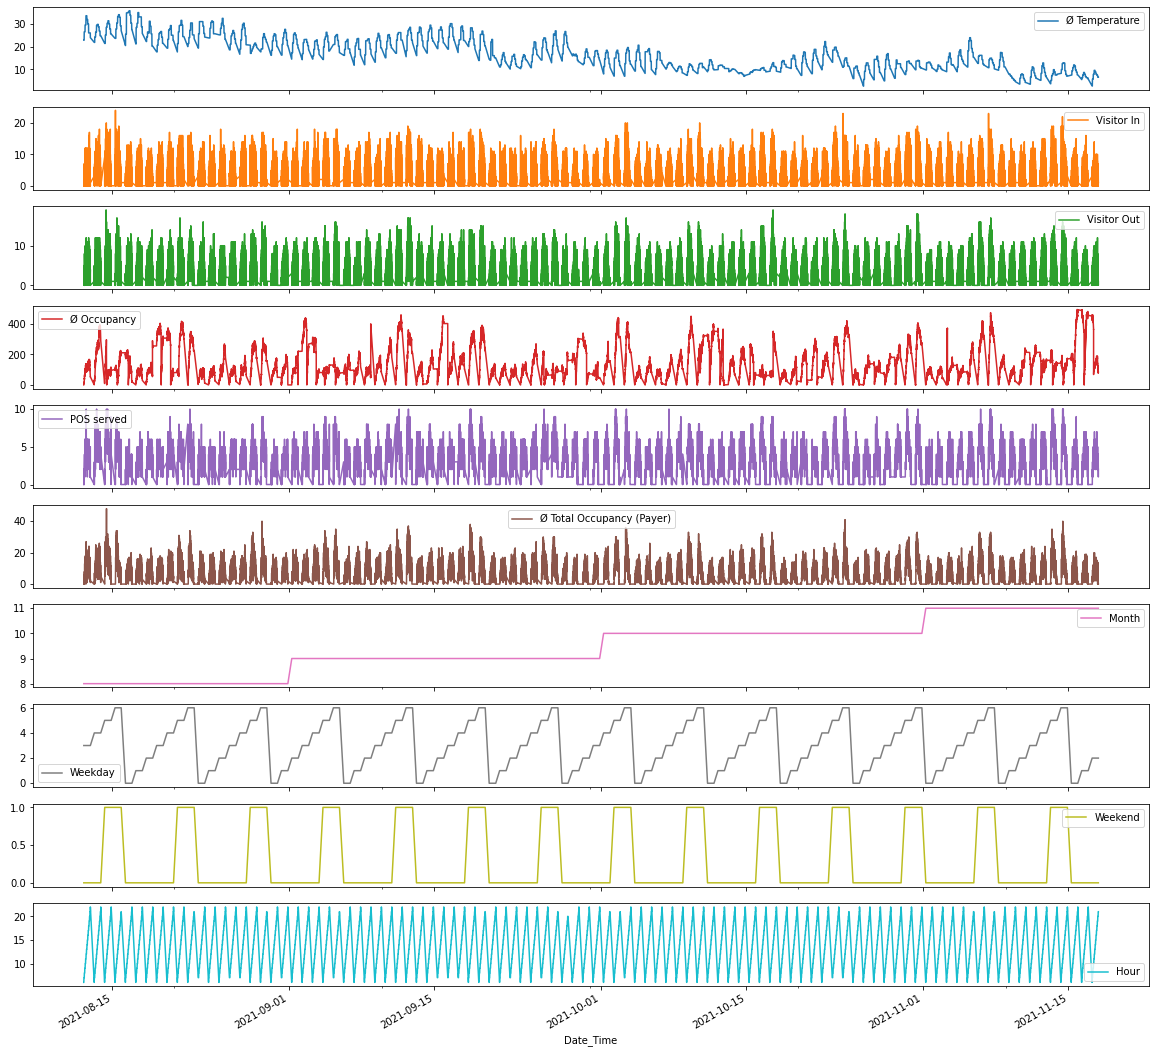

In [ ]:
df.plot(subplots=True, figsize=(20, 20)) 
plt.gcf().autofmt_xdate()
plt.show()

Darstellung der Zielvariable über den gesamten Zeitraum:

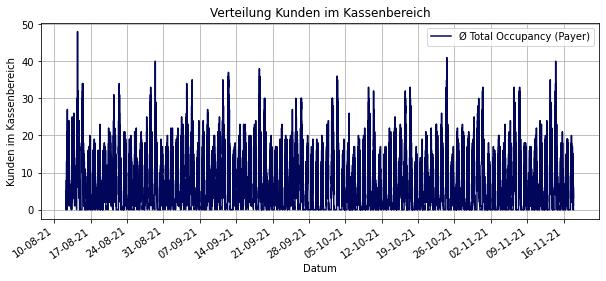

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df['Ø Total Occupancy (Payer)'], color='#01065a', label='Ø Total Occupancy (Payer)')
plt.title('Verteilung Kunden im Kassenbereich')
plt.xlabel('Datum')
plt.ylabel('Kunden im Kassenbereich')
plt.legend()
plt.grid()
plt.gcf().autofmt_xdate()
dtFmt = mdates.DateFormatter('%d-%m-%y')
plt.gca().xaxis.set_major_formatter(dtFmt)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1)) 
plt.xticks(rotation=35)
plt.savefig('payer_all.pdf', bbox_inches = 'tight')
plt.show()

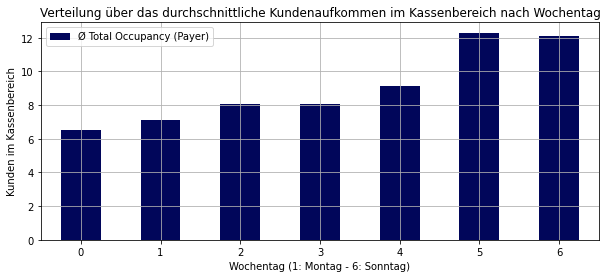

In [ ]:
fig, axs = plt.subplots(figsize=(10, 4))
plt.title('Verteilung über das durchschnittliche Kundenaufkommen im Kassenbereich nach Wochentag')
df.groupby(df.index.weekday)['Ø Total Occupancy (Payer)'].mean().plot(kind='bar', rot=0, ax=axs, color='#01065a', label='Ø Total Occupancy (Payer)')
plt.xlabel('Wochentag (1: Montag - 6: Sonntag)');
plt.ylabel('Kunden im Kassenbereich');
plt.legend()
plt.grid(zorder=0)
plt.savefig('payer_weekday.pdf', bbox_inches = 'tight')
plt.show()

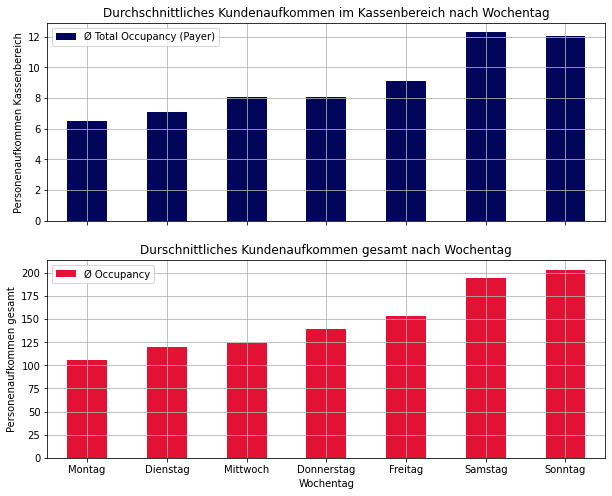

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8), sharex=True)

df.groupby(df.index.weekday)['Ø Total Occupancy (Payer)'].mean().plot(kind='bar', ax=ax1, color='#01065a', rot=0, label='Ø Total Occupancy (Payer)')
ax1.set_ylabel('Personenaufkommen Kassenbereich')
ax1.set_title('Durchschnittliches Kundenaufkommen im Kassenbereich nach Wochentag')
ax1.grid()
ax1.legend()

df.groupby(df.index.weekday)['Ø Occupancy'].mean().plot(kind='bar', ax=ax2, color='#e31134', rot=0, label='Ø Occupancy')
ax2.set_ylabel('Personenaufkommen gesamt')
ax2.set_title('Durschnittliches Kundenaufkommen gesamt nach Wochentag')
ax2.set_xlabel('Wochentag')
ax2.set_xticklabels(['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag'])
ax2.grid()
ax2.legend()

plt.savefig('payer_occupancy_weekday.pdf', bbox_inches = 'tight')
plt.show()


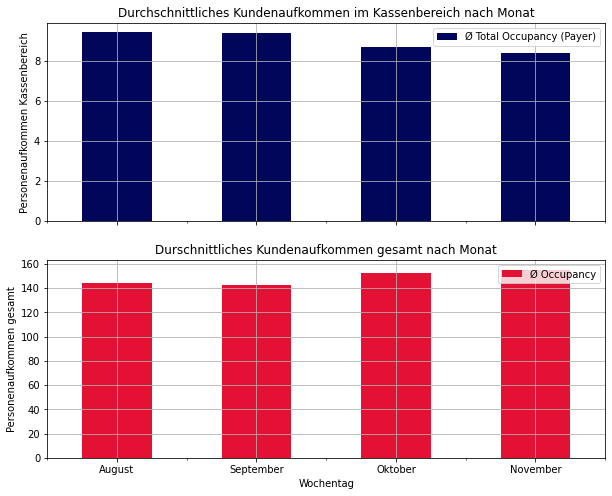

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8), sharex=True)

df.groupby(df.index.month)['Ø Total Occupancy (Payer)'].mean().plot(kind='bar', ax=ax1, color='#01065a', rot=0, label='Ø Total Occupancy (Payer)')
ax1.set_ylabel('Personenaufkommen Kassenbereich')
ax1.set_title('Durchschnittliches Kundenaufkommen im Kassenbereich nach Monat')
ax1.grid()
ax1.legend()

df.groupby(df.index.month)['Ø Occupancy'].mean().plot(kind='bar', ax=ax2, color='#e31134', rot=0, label='Ø Occupancy')
ax2.set_ylabel('Personenaufkommen gesamt')
ax2.set_title('Durschnittliches Kundenaufkommen gesamt nach Monat')
ax2.set_xlabel('Wochentag')
ax2.set_xticklabels(['August', 'September', 'Oktober', 'November'])
ax2.grid()
ax2.legend()

plt.savefig('payer_occupancy_weekday.pdf', bbox_inches = 'tight')
plt.show()

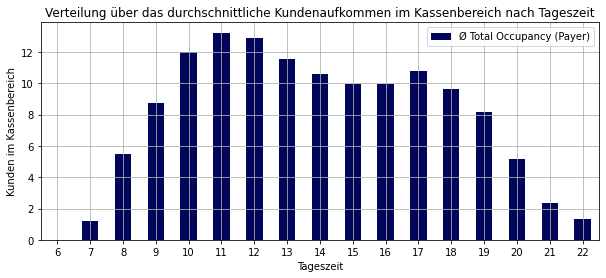

In [ ]:
plt.figure(figsize=(10,4))
axs = plt.gca()
plt.title('Verteilung über das durchschnittliche Kundenaufkommen im Kassenbereich nach Tageszeit')
df.groupby(df.index.hour)['Ø Total Occupancy (Payer)'].mean().plot(kind='bar', rot=0, ax=axs, color='#01065a', label='Ø Total Occupancy (Payer)')
plt.xlabel('Tageszeit');
plt.ylabel('Kunden im Kassenbereich');
plt.legend()
plt.grid(zorder=0)
plt.savefig('payer_hour.pdf', bbox_inches = 'tight')
plt.show()

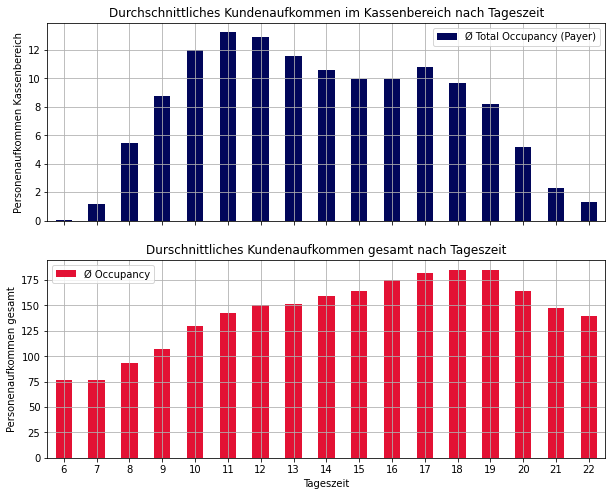

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8), sharex=True)

df.groupby(df.index.hour)['Ø Total Occupancy (Payer)'].mean().plot(kind='bar', ax=ax1, color='#01065a', rot=0, label='Ø Total Occupancy (Payer)')
ax1.set_ylabel('Personenaufkommen Kassenbereich')
ax1.set_title('Durchschnittliches Kundenaufkommen im Kassenbereich nach Tageszeit')
ax1.grid()
ax1.legend()

df.groupby(df.index.hour)['Ø Occupancy'].mean().plot(kind='bar', ax=ax2, color='#e31134', rot=0, label='Ø Occupancy')
ax2.set_ylabel('Personenaufkommen gesamt')
ax2.set_title('Durschnittliches Kundenaufkommen gesamt nach Tageszeit')
ax2.set_xlabel('Tageszeit')
ax2.grid()
ax2.legend()

plt.savefig('payer_occupancy_weekday.pdf', bbox_inches = 'tight')
plt.show()


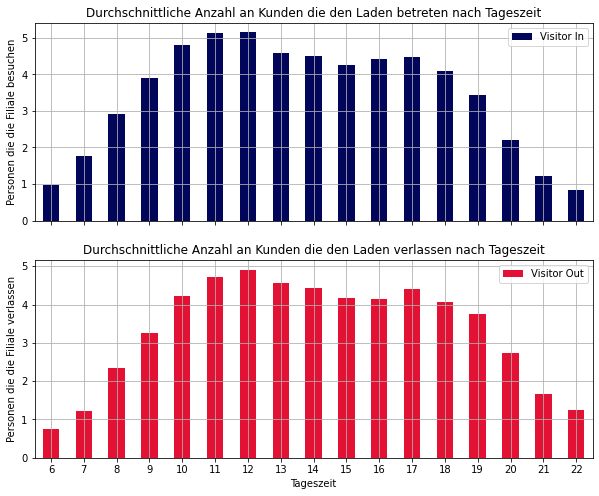

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8), sharex=True)

df.groupby(df.index.hour)['Visitor In'].mean().plot(kind='bar', ax=ax1, color='#01065a', rot=0, label='Visitor In')
ax1.set_ylabel('Personen die die Filiale besuchen')
ax1.set_title('Durchschnittliche Anzahl an Kunden die den Laden betreten nach Tageszeit')
ax1.grid()
ax1.legend()

df.groupby(df.index.hour)['Visitor Out'].mean().plot(kind='bar', ax=ax2, color='#e31134', rot=0, label='Visitor Out')
ax2.set_ylabel('Personen die die Filiale verlassen')
ax2.set_title('Durchschnittliche Anzahl an Kunden die den Laden verlassen nach Tageszeit')
ax2.set_xlabel('Tageszeit')
ax2.grid()
ax2.legend()

plt.savefig('visitor_in_out_weekday.pdf', bbox_inches = 'tight')
plt.show()

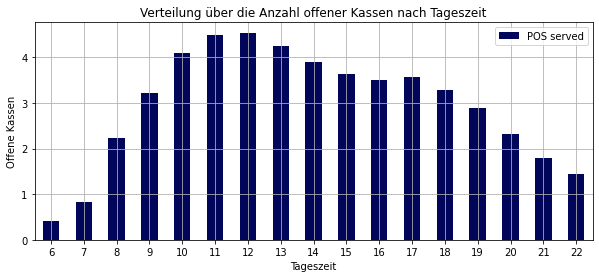

In [ ]:
plt.figure(figsize=(10,4))
axs = plt.gca()
plt.title('Verteilung über die Anzahl offener Kassen nach Tageszeit')
df.groupby(df.index.hour)['POS served'].mean().plot(kind='bar', rot=0, ax=axs, color='#01065a', label='POS served')
plt.xlabel('Tageszeit');
plt.ylabel('Offene Kassen');
plt.legend()
plt.grid(zorder=0)
plt.savefig('POS_hour.pdf', bbox_inches = 'tight')
plt.show()

Hier werden die numerischen Features extrahiert und dann mit Hilfe eines Histograms angezeigt. Somit lässt sich erkennen welche Werte am meisten vorkommen.

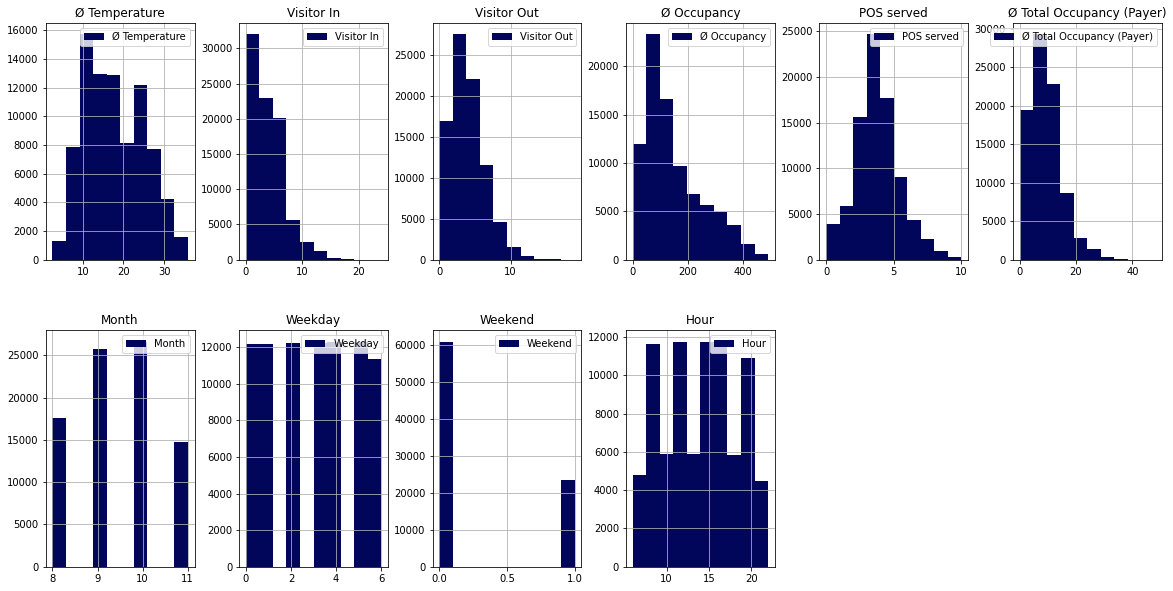

In [ ]:
numerical_headers = df.select_dtypes([np.int64,np.float64]).columns
numerical_att = df.select_dtypes(include=['float64', 'int64'])
numerical_att.hist(figsize=(20,10), layout=(2,6), legend=True, color='#01065a')
plt.show()

Darstellung der numerischen Merkmale ebenfalls als Boxplots:

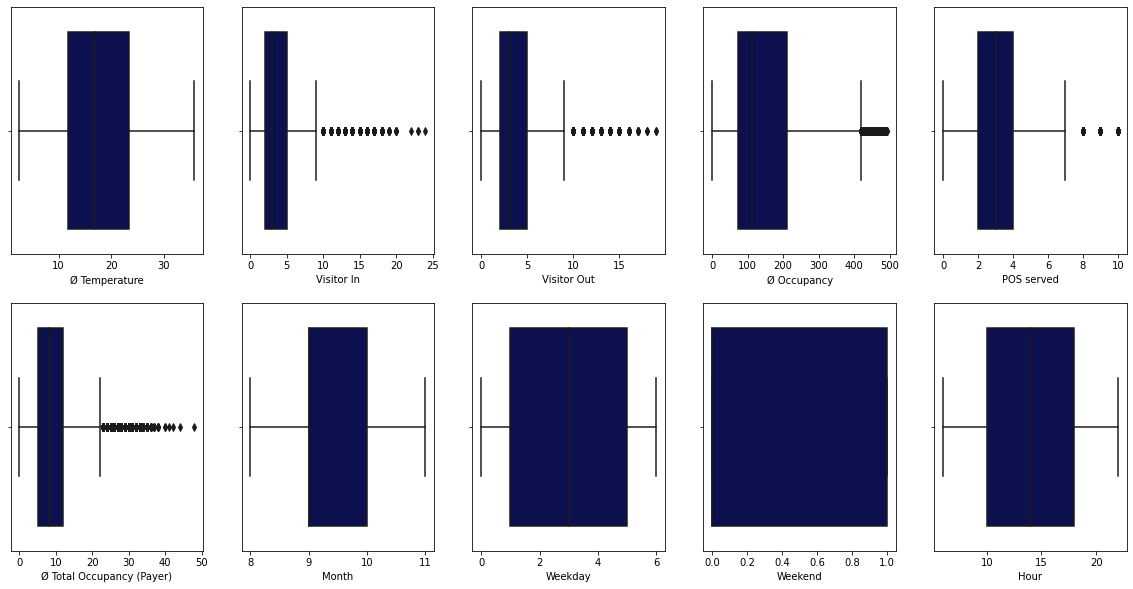

In [ ]:
a = 2  # number of rows
b = 5  # number of columns
c = 1  # initialize plot counter

plt.figure(figsize=(20, 10))

for index, item in enumerate(numerical_headers):
  plt.subplot(a, b, c)
  sns.boxplot(x=df[item], orient="horizontal", color='#01065a')
  c = c+1

plt.show()

### Wetterbeschreibungen anpassen:
Das Merkmal **Weather Description** ist das einzige nicht numerische Merkmal und wird im folgenden angepasst. Das Merkmal enthält eine große Anzahl verschiedener Labels, die oft das selbe aussagen. Damit ein aussagekräftigeres Bild entsteht, ob bei Regen weniger Menschen an der Kasse stehen werden diese Werte zu neuen Gruppen zusammengefasst. Dadurch enthalten diese Gruppen mehr Werte und haben eine größere Aussagekraft.

Unterschiedlichen Werte des Merkmals **Weather Description** ausgeben:

In [ ]:
df['Weather Description'].unique()

array(['clear sky', 'few clouds', 'scattered clouds', 'light rain',
       'broken clouds', 'light intensity shower rain', 'moderate rain',
       'overcast clouds', 'thunderstorm', 'fog', 'mist',
       'light intensity drizzle', 'shower rain'], dtype=object)

Häufigkeitsverteilung der Wetterbeschreibungen vor der Anpassung:

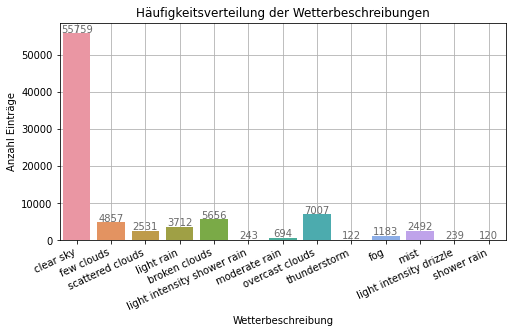

In [ ]:
categorial_att = df.select_dtypes(include=['object'])

df_old_weather = categorial_att.copy()
plt.figure(figsize=(8, 4))
chart = sns.countplot(data=df_old_weather, x='Weather Description')
chart.set_xticklabels(chart.get_xticklabels(), rotation=25, horizontalalignment='right', fontweight='light', fontsize='medium')
chart.set_ylabel('Anzahl Einträge')
chart.set_xlabel('Wetterbeschreibung')
chart.set_title('Häufigkeitsverteilung der Wetterbeschreibungen')
chart.grid()
chart.bar_label(chart.containers[0], label_type='edge', padding=-1, color='dimgray')
chart.set_axisbelow(True)
plt.savefig('weather_describtion_frec.pdf', bbox_inches = 'tight')
plt.show()

Zusammenführen der einzelnen Merkmale:

In [ ]:
df['Weather Description'].replace({
  'clear sky': 'sunny',
  'few clouds': 'cloudy',
  'scattered clouds': 'cloudy', 
  'overcast clouds': 'cloudy', 
  'broken clouds': 'cloudy',
  'light rain': 'rainy',
  'light intensity shower rain': 'rainy',
  'moderate rain': 'rainy',
  'light intensity drizzle': 'rainy',
  'shower rain': 'rainy',
  'moderate rain': 'rainy',
  'thunderstorm': 'stormy',
  'fog': 'misty',
  'mist': 'misty'
}, inplace=True)

Häufigkeitsverteilung der Wetterbeschreibungen nach der Anpassung:

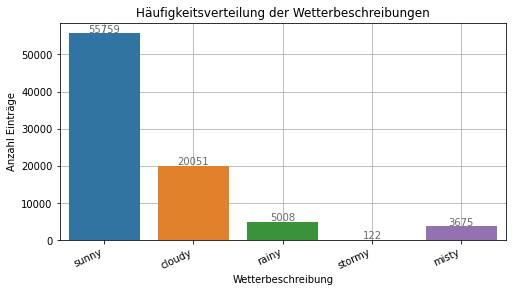

In [ ]:
categorial_att = df.select_dtypes(include=['object'])

plt.figure(figsize=(8, 4))
chart = sns.countplot(data=categorial_att, x='Weather Description')
chart.set_xticklabels(chart.get_xticklabels(), rotation=25, horizontalalignment='right', fontweight='light', fontsize='medium')
chart.set_ylabel('Anzahl Einträge')
chart.set_xlabel('Wetterbeschreibung')
chart.set_title('Häufigkeitsverteilung der Wetterbeschreibungen')
chart.grid()
chart.set_axisbelow(True)
chart.bar_label(chart.containers[0], label_type='edge', padding=-1, color='dimgray')
plt.savefig('weather_describtion_frec_new.pdf', bbox_inches = 'tight')
plt.show()

### Korrelationen zwischen numerischen Merkmalen:

Korrelation zwischen den Einzelnen numerischen Features und der Zielvariable:

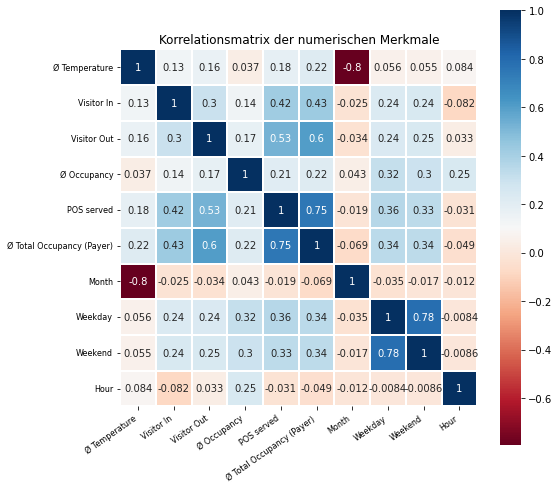

In [ ]:
corr = df.corr()

f, ax = plt.subplots(figsize=(8,8))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

data_heatmap = sns.heatmap(data=corr, cmap='RdBu', square=True, ax=ax, annot=True, linewidths=0.1)

plt.yticks(fontsize=8)
plt.xticks(rotation=35, ha="right", fontsize=8)
plt.title('Korrelationsmatrix der numerischen Merkmale')
plt.savefig('correlation_matrix.pdf', bbox_inches = 'tight')
plt.show()

Korrelation zwischen den einzelnen numerischen Attributen:

In [ ]:
for element in numerical_headers[0:5]:
  fig = px.scatter(numerical_att, title="Korrelation Ø Total Occupancy (Payer) und " + element, x=element, y="Ø Total Occupancy (Payer)", width=1000, height=500)
  fig.show()

In [ ]:
for element in numerical_headers[5:11]:
  fig = px.scatter(numerical_att, title="Korrelation Ø Total Occupancy (Payer) und " + element, x=element, y="Ø Total Occupancy (Payer)", width=1000, height=500)
  fig.show()

### Ausgabe der numerischen Werte nach Wochen und Monaten 

In [ ]:
data_weekly_mean = df[numerical_headers].resample('W').mean() # W stands for weekly
data_weekly_mean

Ø Temperature  Visitor In  ...   Weekend       Hour
Date_Time                              ...                     
2021-08-15      28.450405    4.862267  ...  0.482927  13.979914
2021-08-22      27.449051    3.873565  ...  0.273403  14.009054
2021-08-29      25.181089    3.763880  ...  0.274004  14.040496
2021-09-05      22.087099    3.896496  ...  0.271068  13.987938
2021-09-12      21.879729    4.195455  ...  0.275325  13.995779
2021-09-19      24.963859    4.030671  ...  0.281450  14.112022
2021-09-26      17.287916    3.758292  ...  0.279803  14.143021
2021-10-03      16.763118    3.806130  ...  0.290147  13.033847
2021-10-10      13.184122    3.650700  ...  0.286091  13.912099
2021-10-17      10.242260    3.677822  ...  0.284613  13.972441
2021-10-24      14.868922    3.568940  ...  0.274774  13.979129
2021-10-31      11.675763    3.886386  ...  0.278900  13.907585
2021-11-07      14.212688    3.822894  ...  0.276624  13.831035
2021-11-14       8.850551    3.987527  ...  0.282127  13.928442
2021-11-21       8.139618    3.256597  ...  0.000000  13.893308

[15 rows x 10 columns]

In [ ]:
data_monthly_mean = df[numerical_headers].resample('M').mean() # M stands for monthly
data_monthly_mean

Ø Temperature  Visitor In  ...   Weekend       Hour
Date_Time                              ...                     
2021-08-31      26.399674    3.968691  ...  0.287585  14.022770
2021-09-30      21.002637    3.924934  ...  0.263528  13.931815
2021-10-31      12.765347    3.778772  ...  0.314772  13.869045
2021-11-30      10.915847    3.790453  ...  0.229782  13.882393

[4 rows x 10 columns]

In [ ]:
df.groupby(['Weekday']).mean()

Ø Temperature  Visitor In  Visitor Out  ...     Month  Weekend       Hour
Weekday                                          ...                              
0            18.192995    3.109538     3.056374  ...  9.498148      0.0  13.983376
1            16.826979    3.244605     3.172069  ...  9.497087      0.0  13.941495
2            16.590330    3.486141     3.371658  ...  9.568640      0.0  13.901591
3            17.785877    3.415417     3.304252  ...  9.350045      0.0  13.944212
4            18.260900    3.870453     3.713321  ...  9.413215      0.0  13.954105
5            18.237375    4.903479     4.596031  ...  9.416626      1.0  13.900212
6            18.606938    5.102636     4.809100  ...  9.439644      1.0  13.824795

[7 rows x 9 columns]

## One-Hot-Encoding und Export:
Hierbei wurde ein Datensatz exportiert, der die Wetterinformationen enthält und einer, der diese nicht enthält um die Auswirkung zu erkennen.

In [ ]:
df_no_weather_temp = df.drop(['Weather Description',	'Ø Temperature'], axis=1)
display(df_no_weather_temp.head(5))

Visitor In  Visitor Out  ...  Weekend  Hour
Date_Time                                     ...               
2021-08-12 06:56:00           1            1  ...        0     6
2021-08-12 06:58:00           0            1  ...        0     6
2021-08-12 06:59:00           1            1  ...        0     6
2021-08-12 07:00:00           2            0  ...        0     7
2021-08-12 07:01:00           3            0  ...        0     7

[5 rows x 9 columns]

In [ ]:
df_no_weather_temp.to_csv(path_or_buf='/content/drive/MyDrive/sensalytics/Rohdaten/data_without_weather.csv')

One-Hot-Encoding des Merkmals **Weather Description** mit der Funktion *get_dummies()* von Pandas:

In [ ]:
dataset = pd.get_dummies(data=df, columns=['Weather Description'], prefix='', prefix_sep='')
dataset.head(5)

Ø Temperature  Visitor In  ...  stormy  sunny
Date_Time                                       ...               
2021-08-12 06:56:00          22.83           1  ...       0      1
2021-08-12 06:58:00          22.83           0  ...       0      1
2021-08-12 06:59:00          22.83           1  ...       0      1
2021-08-12 07:00:00          22.83           2  ...       0      1
2021-08-12 07:01:00          22.83           3  ...       0      1

[5 rows x 15 columns]

In [ ]:
dataset.to_csv(path_or_buf='/content/drive/MyDrive/sensalytics/Rohdaten/data_with_weather.csv')